Hackaton

# Index
1. Reading the data
2. Exploratory Data Analysis
    1. Target Variable Distrubution (check if its inbalanced)
    2. Distribution of features
    3. Missing values of features
    4. Correlation of features
    5. Description of the data (df.describe())
    6. Outlier detection (remove nonsensical data / boxplots) / (create a function to remove outliers)
    7. Check distinct values in features / check ordinal values
3. Feature Engineering
    1. Missing value imputation (mode, median, mean, k-NN, SMOTE etc.)
    2. Create new features using arithmetical transformations of existing features.
    3. PCA 
    4. Try few models to decide feature importances to reduce features. (target shuffling)
    5. Add new features using outside data sources.
    6. Train, Test, Validation split (use validation for hyperparameter tuning)
4. Modeling (find important features using models, then return to feature engineering)
    1. Linear Regression (remove multicolonarity, then check coefficient of features to determine their importance) (correlation matrix 85%>)
    2. Decision Tree
    3. Random Forest (entropy)
    4. XGBoost
    5. LightGBM
    6. Neural Network
    7. Ensemble Learning
5. Hyperparameter Tuning
    1. Grid Search
    2. Bayesean Search


    

# Dependencies

In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model as lin 
from sklearn import preprocessing as pre
from sklearn import metrics as met
from sklearn import model_selection as mod
from sklearn import pipeline as pip
from sklearn import datasets as dat
from sklearn import tree
from sklearn import preprocessing as pre
from sklearn import ensemble as ens
from sklearn import svm
from sklearn import decomposition as dec
from sklearn import manifold as man
from sklearn import impute as imp
from sklearn import compose as com

from imblearn import pipeline as imbPip # imblearn pipeline
from imblearn import under_sampling as und
from imblearn import over_sampling as ove

import xgboost as xgb

import seaborn as sns

np.set_printoptions(suppress=True) 

import warnings
warnings.filterwarnings("ignore")

# Functions

In [3]:
def plotLearningCurve(est, X_train, y_train, X_test, y_test, n_iter=10, minY=0,maxY=1):
    x_values = [] #number of training samples
    y_values_train = []
    y_values_test = []

    for i in np.linspace(10,len(X_train),n_iter): #increase training sizes by every iter
        i=int(i)
        #select a subset of training data
        X_train_temp = X_train[:i]
        y_train_temp = y_train[:i]
        #create the model
        est.fit(X_train_temp, y_train_temp)
        #evaluate train set
        y_pred_train=est.predict(X_train_temp)
        train_score = met.mean_squared_error(y_train_temp,y_pred_train,squared=False)
        #evaluate test set
        y_pred_test=est.predict(X_test)
        test_score = met.mean_squared_error(y_test,y_pred_test,squared=False)
        #populate lists
        y_values_train.append(train_score)
        y_values_test.append(test_score)
        x_values.append(i)
    plt.figure(figsize=(10,6))
    plt.plot(x_values,y_values_train,label="Train")
    plt.plot(x_values,y_values_test, label="Test")
    plt.legend()
    plt.ylabel("RMSE")
    plt.xlabel("# of training samples")
    plt.grid(True)
    plt.ylim(minY,maxY)
    plt.show()

In [4]:
def plotDecisionBoundaries(clf, X, y, n_classes=2):
  # Parameters
  plot_colors = "rb"
  plot_step = 0.02

  X2 = X.values
  y_now = y.values


  for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                  [1, 2], [1, 3], [2, 3]]):
      # We only take the two corresponding features
      X_now = X2[:, pair]
      
      

      # Train
      clf.fit(X_now, y_now)

      # Plot the decision boundary
      plt.subplot(2, 3, pairidx + 1)

      x_min, x_max = X_now[:, 0].min() - 1, X_now[:, 0].max() + 1
      y_min, y_max = X_now[:, 1].min() - 1, X_now[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                          np.arange(y_min, y_max, plot_step))
      plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = Z.reshape(xx.shape)
      cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

      

      # Plot the training points
      for i, color in zip(range(n_classes), plot_colors):
          idx = np.where(y_now == i)
          
          plt.scatter(X_now[idx, 0], X_now[idx, 1], c=color,
                      cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

  plt.suptitle("Decision surface of a decision tree using paired features")
  plt.legend(loc='lower right', borderpad=0, handletextpad=0)
  plt.axis("tight")
  plt.show()

In [5]:
def estimate_roc_curve(X_train, y_train_binary, estimators=[[tree.DecisionTreeClassifier(random_state=42),
                lin.SGDClassifier(random_state=42),
                ens.RandomForestClassifier(random_state=42)]]):
    for est in estimators:
        pipe = pip.Pipeline([
            ("scaler", pre.StandardScaler()),
            ("est",est)
        ])
        if hasattr(est,"predict_proba"):
            myMethod = "predict_proba" #returns list of lists
        else:
            myMethod = "decision_function" 

        y_scores = mod.cross_val_predict(pipe, X_train, y_train_binary,
                                        cv=5, method=myMethod)
        if myMethod == "predict_proba":
            y_scores = y_scores[:, 1] #probabilities for true class
        fpr, tpr, thresholds = met.roc_curve(y_train_binary,y_scores)
        auc_score = met.roc_auc_score(y_train_binary,y_scores)
        print(est.__class__.__name__,auc_score)
        plt.plot(fpr, tpr, label=est.__class__.__name__)
    plt.title("ROC Curve")
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend()
    plt.show()

In [6]:
def precision_recall_curve(est, X_train, y_train_binary):
    
    pipe = pip.Pipeline([("scaler", pre.StandardScaler())
                         ,("est",est)])
    
    if hasattr(est,"predict_proba"):
        myMethod = "predict_proba" 
    else:
        myMethod = "decision_function" 
    
    y_scores = mod.cross_val_predict(pipe,X_train,y_train_binary,cv=3, method=myMethod)
    
    precision, recall, thresholds = met.precision_recall_curve(y_train_binary, y_scores)
    
    plt.figure(figsize=(10,6))
    plt.plot(thresholds,precision[:-1], label = "precision")
    plt.plot(thresholds,recall[:-1], label = "recall")
    plt.legend()
    plt.xlabel("Thresholds")
    plt.ylabel("Precision / Recall")
    plt.show()
    
    fpr, tpr, thresholds = met.roc_curve(y_train_binary,y_scores)
    plt.plot(fpr,tpr)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.show()
    

# Main

## 1. Reading the Data

In [10]:
Data_Path = "data/train.csv" #replace with data path
Target_Col = "RainTomorrow"

In [11]:
df = pd.read_csv(Data_Path)
df.head()

,ID,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2013-08-30,Perth,13.4,20.2,5.2,1.4,5.9,WNW,50.0,...,67.0,73.0,1008.5,1006.7,4.0,6.0,18.8,18.7,Yes,1
1,1,2010-12-24,Brisbane,21.8,27.7,0.2,3.2,0.2,SSE,41.0,...,71.0,81.0,1016.9,1015.3,7.0,8.0,26.8,25.2,No,1
2,2,2008-02-13,Sydney,18.4,22.8,14.4,7.0,3.3,NaN,NaN,...,87.0,70.0,1009.2,1011.7,8.0,7.0,20.9,21.0,Yes,1
3,3,2014-10-07,Sydney,19.7,27.9,0.0,8.0,7.7,NW,61.0,...,44.0,30.0,1007.8,1008.3,7.0,1.0,24.1,25.2,No,1
4,4,2013-09-08,Bendigo,2.7,18.4,0.2,3.1,NaN,NW,20.0,...,71.0,56.0,1027.8,1024.2,NaN,1.0,12.0,17.8,No,0


In [21]:
num_columns = list(df.drop(Target_Col,axis=1).select_dtypes(exclude="object").columns)
cat_columns = list(df.select_dtypes(include="object").columns)

## 2. Exploratory Data Analysis 

### 1. Target Variable Distribution

In [20]:
df[Target_Col].value_counts(normalize=True, dropna=False)

0    0.775173
1    0.224827
Name: RainTomorrow, dtype: float64

## 2. Distribution of Features

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'MinTemp'}>,
        <AxesSubplot:title={'center':'MaxTemp'}>,
        <AxesSubplot:title={'center':'Rainfall'}>],
       [<AxesSubplot:title={'center':'Evaporation'}>,
        <AxesSubplot:title={'center':'Sunshine'}>,
        <AxesSubplot:title={'center':'WindGustSpeed'}>,
        <AxesSubplot:title={'center':'WindSpeed9am'}>],
       [<AxesSubplot:title={'center':'WindSpeed3pm'}>,
        <AxesSubplot:title={'center':'Humidity9am'}>,
        <AxesSubplot:title={'center':'Humidity3pm'}>,
        <AxesSubplot:title={'center':'Pressure9am'}>],
       [<AxesSubplot:title={'center':'Pressure3pm'}>,
        <AxesSubplot:title={'center':'Cloud9am'}>,
        <AxesSubplot:title={'center':'Cloud3pm'}>,
        <AxesSubplot:title={'center':'Temp9am'}>],
       [<AxesSubplot:title={'center':'Temp3pm'}>,
        <AxesSubplot:title={'center':'RainTomorrow'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

<Figure size 1500x1100 with 0 Axes>

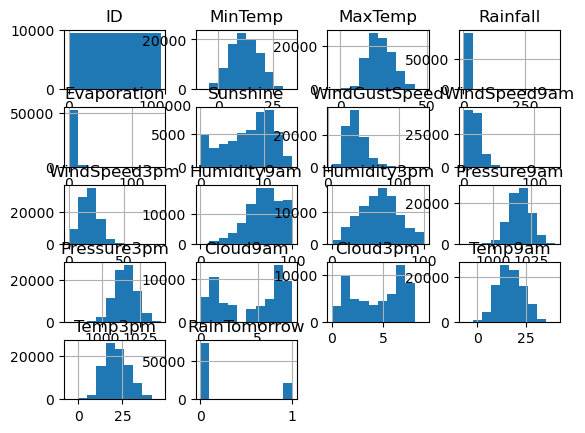

In [23]:
plt.figure(figsize=(15,11))
df.hist()